In [67]:
# Input data files are available in the "../input/" directory.
import os

import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [68]:
import pandas as pd 
gsheet_id = "1CUTqwKU87M88kdXYg4qZizwtSBYxPNPQ-hKDDfDqh-E"
gsheet_name = "file_50"

In [69]:
gsheet_url = "https://docs.google.com/spreadsheets/d/{}/gviz/tq?tqx=out:csv&sheet={}".format(gsheet_id,gsheet_name)

In [70]:
data = pd.read_csv(gsheet_url)

In [71]:
docIds = data["id"]
doc_titles = data["built-in function id"]
doc_contents = data["text"]
categories =data["cat"]

In [72]:
#(token_bodies, token_titles) = tokenizeDocs(docTitles, docBodies);
# concatenate title, body with space into tokenText
#tokenText = [token_titles[i] + " " + token_bodies[i] for i in xrange(len(token_titles))]
import pandas as pd
data = pd.DataFrame({id: docIds});
data["text"] = doc_contents;
data["cat"] = categories;

**Number of Words in Text Label**

In [73]:
print(data['text'].apply(lambda x: len(x.split(' '))).sum())

20604


In [74]:
# Create a new dataframe with two columns
data1 = data[['text', 'cat']].copy()

# Remove missing values (NaN)
#df1 = df1[pd.notnull(df1['Consumer complaint narrative'])]

# Renaming second column for a simpler name
data1.columns = ['Text', 'Categories'] 

data1.shape

(50, 2)

List of Categories in Data

In [75]:
pd.DataFrame(data.cat.unique()).values

array([['accident'],
       ['life'],
       ['politics'],
       ['entertainment']], dtype=object)

# **Category ID**
Create category ID to represent each class as a number, so as our predictive model can better understand the different categories.



*   0 : accident
*   1 : life
*   2 : politics
*   3 : entertainment



In [76]:
# Create a new column 'category_id' with encoded categories 
data1['category_id'] = data1['Categories'].factorize()[0]
category_id_df = data1[['Categories', 'category_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Categories']].values)

# New dataframe
data1.head()

,Text,Categories,category_id
0,ដោយសារតែ បើកបរ លឿន ជិត ៗ គ្នា ពេក រថយន្ត ៦ គ្...,accident,0
1,រថយន្ត តារា កំប្លែង ជើង ចាស់ នាយ កុយ បែក កង់...,accident,0
2,ជនជាតិ យូក្រែន ម្នាក់ ក្រឡាប់ រថយន្ត នៅ ស្រុក...,accident,0
3,ខ្លាំង ម្ល៉េះ ! គេ ជួយ ប្រាប់ ខ្លាច បង្ក គ្រោ...,life,1
4,លិខិត មិត្ត អ្នកអាន៖ « នយោបាយ ក្តិច ត្រួយ ជា ...,politics,2


**CHART FOR EACH CATEGORY**

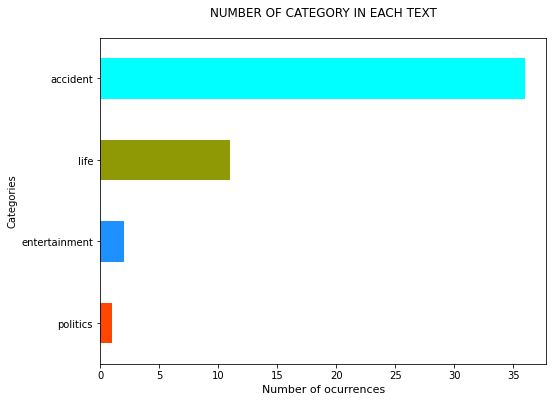

In [77]:
fig = plt.figure(figsize=(8,6))
colors = ['#FF4500','#1E90FF','#8f9805','#00FFFF']
data1.groupby('Categories').Text.count().sort_values().plot.barh(ylim=0, color=colors, title= 'NUMBER OF CATEGORY IN EACH TEXT\n')
plt.xlabel('Number of ocurrences', fontsize = 11);

# **Text Pre-Processing**
The text needs to be transformed to vectors so as the algorithms will be able make predictions. In this case it will be used the Term Frequency – Inverse Document Frequency (TFIDF) weight to evaluate how important a word is to a document in a collection of documents.



In [78]:
#from sklearn.feature_extraction.text import TfidfVectorizer
#state in 1st already
def tokenizersplit(str):
    return str.split();

tfidf = TfidfVectorizer(min_df=0.005, tokenizer=tokenizersplit, encoding='utf-8')
#Try change parameters around 
#tfidf = TfidfVectorizer(tokenizer=tokenizersplit, encoding="utf-8", min_df=2, ngram_range=(1, 2), max_features=25000)

#2 class version
#tfidf_vect = tfidf.fit(data["text"])
#tfidf_vect.transform(data["text"])

#New version
#tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
#                        ngram_range=(1, 2), 
#                       stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(data1.Text).toarray()

labels = data1.category_id


print("Each of the %d text is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))


Each of the 50 text is represented by 2323 features (TF-IDF score of unigrams and bigrams)


In [79]:
# Finding the three most correlated terms with each of the product categories
N = 3
for Categories, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> %s:" %(Categories))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> accident:
  * Most Correlated Unigrams are: ថ្លឹង, volvo, លោក
  * Most Correlated Bigrams are: 

==> entertainment:
  * Most Correlated Unigrams are: អគារ, cars, volvo
  * Most Correlated Bigrams are: 

==> life:
  * Most Correlated Unigrams are: ជញ្ជីង, ថ្លឹង, លោក
  * Most Correlated Bigrams are: 

==> politics:
  * Most Correlated Unigrams are: នយោបាយ, បក្ស, ប្រឆាំង
  * Most Correlated Bigrams are: 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is d

**Spliting the data into train and test sets**

In [80]:
X = data1['Text'] # Collection of documents
y = data1['Categories'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20,
                                                    random_state = 0)

In [81]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


In [82]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.84,0.054772
LogisticRegression,0.72,0.044721
MultinomialNB,0.72,0.044721
RandomForestClassifier,0.76,0.054772


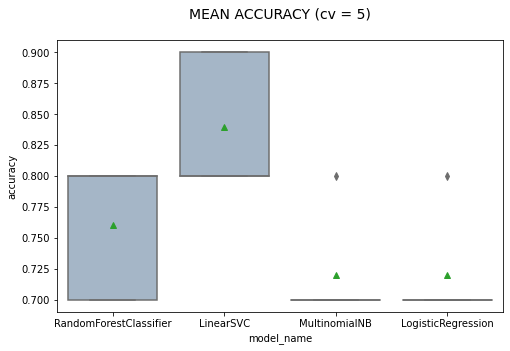

In [83]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='#9FB6CD', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

In [84]:
#labels = data1.category_id
#labels = [0, 1, 2, 3]
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               data1.index, test_size=0.20, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In here, we can see we're missing Categories[2]=politics. The reason is because we only have 1 articles about politics so it's possible it's not included in Test set. 
Solution: try to increse number of politics articles and run this again.

In [85]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
#print(metrics.classification_report(y_test, y_pred, target_names= data1['Categories'].unique()))
print(metrics.classification_report(y_test, y_pred))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         6
           1       0.00      0.00      0.00         3
           3       1.00      1.00      1.00         1

    accuracy                           0.70        10
   macro avg       0.56      0.67      0.60        10
weighted avg       0.50      0.70      0.58        10



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **Confusion Matrix**

Research About THIS!!

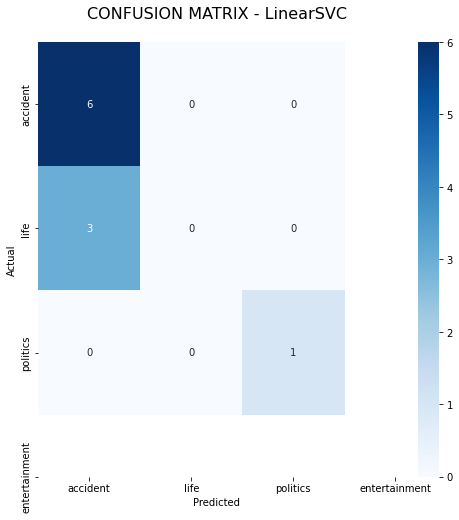

In [86]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Categories.values, 
            yticklabels=category_id_df.Categories.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

# **Misclassified complaints**

In [87]:
data1.head(10)

,Text,Categories,category_id
0,ដោយសារតែ បើកបរ លឿន ជិត ៗ គ្នា ពេក រថយន្ត ៦ គ្...,accident,0
1,រថយន្ត តារា កំប្លែង ជើង ចាស់ នាយ កុយ បែក កង់...,accident,0
2,ជនជាតិ យូក្រែន ម្នាក់ ក្រឡាប់ រថយន្ត នៅ ស្រុក...,accident,0
3,ខ្លាំង ម្ល៉េះ ! គេ ជួយ ប្រាប់ ខ្លាច បង្ក គ្រោ...,life,1
4,លិខិត មិត្ត អ្នកអាន៖ « នយោបាយ ក្តិច ត្រួយ ជា ...,politics,2
5,បុរស ម្នាក់ បាន ស្លាប់ បាត់បង់ជីវិត ភ្លាម ៗ ...,accident,0
6,ឲ្យ ក្មេង មិន ទាន់ គ្រប់ អាយុ បើក ឡាន បុក គេ ...,accident,0
7,ភ្លើង ទៀន ធូប បង្កឲ្យ ឆេះ ផ្ទះ និង សម្ភារះ ទ្...,life,1
8,ការិយាល័យ ចរាចរណ៍ ជើង គោក រាជធានី ភ្នំពេញ បន...,life,1
9,រថយន្ត ដឹក ស្រូវ បុក រថយន្ត ហ៊ីយ៉ាន់ដាយ ពេញ ទំ...,accident,0


In [88]:
data

,<built-in function id>,text,cat
0,0,ដោយសារតែ បើកបរ លឿន ជិត ៗ គ្នា ពេក រថយន្ត ៦ គ្...,accident
1,1,រថយន្ត តារា កំប្លែង ជើង ចាស់ នាយ កុយ បែក កង់...,accident
2,2,ជនជាតិ យូក្រែន ម្នាក់ ក្រឡាប់ រថយន្ត នៅ ស្រុក...,accident
3,3,ខ្លាំង ម្ល៉េះ ! គេ ជួយ ប្រាប់ ខ្លាច បង្ក គ្រោ...,life
4,4,លិខិត មិត្ត អ្នកអាន៖ « នយោបាយ ក្តិច ត្រួយ ជា ...,politics
5,5,បុរស ម្នាក់ បាន ស្លាប់ បាត់បង់ជីវិត ភ្លាម ៗ ...,accident
6,6,ឲ្យ ក្មេង មិន ទាន់ គ្រប់ អាយុ បើក ឡាន បុក គេ ...,accident
7,7,ភ្លើង ទៀន ធូប បង្កឲ្យ ឆេះ ផ្ទះ និង សម្ភារះ ទ្...,life
8,8,ការិយាល័យ ចរាចរណ៍ ជើង គោក រាជធានី ភ្នំពេញ បន...,life
9,9,រថយន្ត ដឹក ស្រូវ បុក រថយន្ត ហ៊ីយ៉ាន់ដាយ ពេញ ទំ...,accident
